[View in Colaboratory](https://colab.research.google.com/github/hlecuanda/jupyter-notebooks-of-all-kinds/blob/master/InSoc.ipynb)

# Decoding data hidden in Information Society's Songs from the album "HACK"

## Background

I have been a long time an of [Information Society][1]. One of their best albums, as any diehard fan knows is, of course ***[HACK][2]*** (Released Oct 16, 1990).


In this album there are two tracks that contain data as part of the music, in particular there is a phone number encoded using ***dual tone multiple frequency signaling*** (or **[DTMF][3]** for short) at the beginning of track  titled #8 *"Hard currency"*.  

I'm sure that someone has already decoded al this, some time in the almost 20 years since it was released, and I could just google it, but, *where is the fun in that?* 

So this notebook is an attempt to decode the data using python tools and libraries. 

**NOTE**: This notebook is intended for those new to python, jupyter notebooks and colab, so explanations may be a bit on the verbose side.


[1]: https://informationsociety.us/
[2]: https://en.wikipedia.org/wiki/Hack_(album)
[3]: https://en.wikipedia.org/wiki/Dual-tone_multi-frequency_signaling

## Download the required libraries

We need to install youtube-dl and ffmpeg. this will generate a sizable output, so we use colab's output handling to keep things tidy.

In [1]:
!pip install youtube-dl # for song download
!pip install pydub      # splitting audio files and stuff

import sys
import time
from google.colab import output

def aptget(cmd):
    tag='apt-get-{}'.format(cmd.replace(' ','-'))
    with output.use_tags(tag):
        print('Executing {} \n'.format(cmd))
        !apt-get $cmd
        sys.stdout.flush()
        
    output.clear(output_tags=tag)
    print('Executing {} ... Done. (output hidden for tidyness)'.format(cmd))
    
aptget('update')
aptget('upgrade')
aptget('install ffmpeg')



import math
import struct
import wave

import matplotlib.pyplot as plt
import numpy as np

from pydub import AudioSegment

Executing update ... Done. (output hidden for tidyness)
Executing upgrade ... Done. (output hidden for tidyness)
Executing install ffmpeg ... Done. (output hidden for tidyness)


## Hard Currency

The song in question is one of my favorites, consisting of mostly sampled dialogue from star trek and other movies where they mention increasing amounts of money, repeatedly. The lyirics are very simple and purportedly, a criticism of materialism and those who seek financial rewards over intelectual pursuits. Or it could be just samples that sound good together. 

However, the first couple of seconds do incliude a distinctive sound that we can all recognize as a phone dialer doing it's thing: DTMF.

Let's find out what data, if any is encoded in this track.



In [2]:
%%html
<iframe width="560" 
        height="315" 
        src="https://www.youtube-nocookie.com/embed/xTONw5gQXJY?rel=0" 
        frameborder="0" 
        allow="encrypted-media" 
        allowfullscreen>
</iframe>


Downloading audio from a youtube video is outside the scope of this notebook, however we do have the aforementioned first few seconds available here:


In [3]:
# Uncomment to re-download file 
#!rm -v *.wav

import youtube_dl

HARDCURRENCY_ID='xTONw5gQXJY'
HARDCURRENCY_WAV='{}.wav'.format(HARDCURRENCY_ID)
DTMF = 'DTMF.wav'

ydl_opts = {
    'format': 'bestaudio/best',
    'outtmpl':'%(id)s.%(ext)s',

    'postprocessors': [{
        'key': 'FFmpegExtractAudio',
        'preferredcodec': 'wav',
        'preferredquality': '192',
    }],
}

with youtube_dl.YoutubeDL(ydl_opts) as ydl:
    ydl.download(['http://www.youtube.com/watch?v={}'.format(HARDCURRENCY_ID)])
    


[youtube] xTONw5gQXJY: Downloading webpage
[youtube] xTONw5gQXJY: Downloading video info webpage
[download] Destination: xTONw5gQXJY.m4a
[download] 100% of 2.34MiB in 00:00
[ffmpeg] Correcting container in "xTONw5gQXJY.m4a"
[ffmpeg] Destination: xTONw5gQXJY.wav
Deleting original file xTONw5gQXJY.m4a (pass -k to keep)


We now define `plot_wave` and  `slice_wave` so we can use them repeatedly


In [0]:
def plot_wave(wavefile,title=""):
    ''' Plots a Waveform '''

    spf = wave.open(wavefile,'r')

    #Extract Raw Audio from Wav File
    signal = spf.readframes(-1)
    signal = np.fromstring(signal, 'Int16')
    fs = spf.getframerate()

    Time=np.linspace(0, len(signal)/fs, num=len(signal))

    plt.figure(1)
    plt.title('{} Waveform...'.format(title))
    plt.plot(Time,signal)
    plt.show()
    
def slice_wave(waveform_in,waveform_out,start_seconds,end_seconds):
    ''' Cuts waveform from start_seconds to end_seconds, 
        writing this to waveform_out, and discarding the rest. '''

    t1 = start_seconds * 1000 #Works in milliseconds
    t2 = end_seconds  * 1000

    newAudio = AudioSegment.from_wav(waveform_in)
    newAudio = newAudio[t1:t2]
    newAudio.export(waveform_out, format="wav")
    

Let's have a look at our recently downloaded song:

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  


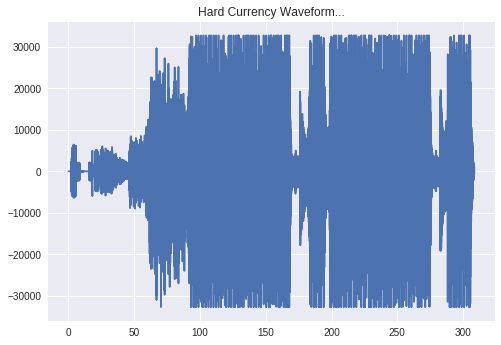

In [5]:

plot_wave(HARDCURRENCY_WAV,"Hard Currency")

We only need the firstcouple of seconds from this file, which hold the DTMF data,  so we import the `AudioSegment` class from `pydub` and discard the rest.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  


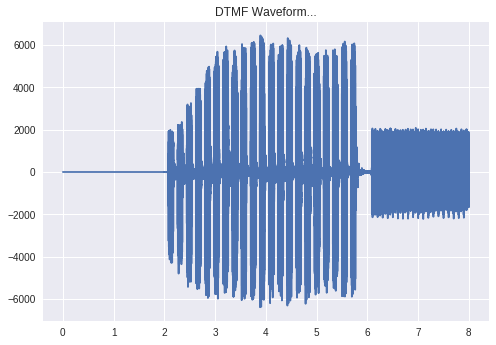

In [6]:
START = 0
END = 4

slice_wave(HARDCURRENCY_WAV,"DTMF1.wav",START,END )
plot_wave("DTMF1.wav","DTMF")

Visually inspecting the waveform, we can easily determine that the DTMF daa starts just before 

$ t=2s $ 

and ends around 

$ t=6s $

Also, the very compact wafeform from 

$t=6s$ to $t=8s$ 

is the first [ringback tone][4]

So we chop our waveform again, to get just the segment with the DTMF data

[4]: https://en.wikipedia.org/wiki/Ringing_tone

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  


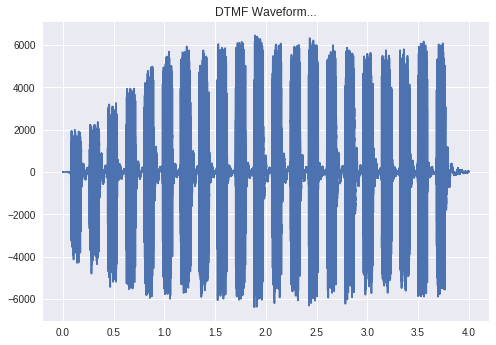

In [7]:
START = 1
END = 3

slice_wave(HARDCURRENCY_WAV,DTMF,START,END )
plot_wave(DTMF,"DTMF")

In [0]:
class Goertzel:
    '''A python implementation of the Goertzel algorithm to decode DTMF tones.'''

    def __init__(self, samplerate):
        self.samplerate = samplerate
        self.goertzel_freq = [1209.0,1336.0,1477.0,1633.0,697.0,770.0,852.0,941.0]
        self.s_prev = {}
        self.s_prev2 = {}
        self.totalpower = {}
        self.N = {}
        self.coeff = {}
        
        # create goertzel parameters for each frequency so that
        # all the frequencies are analyzed in parallel
        for k in self.goertzel_freq:
            self.s_prev[k] = 0.0
            self.s_prev2[k] = 0.0
            self.totalpower[k] = 0.0
            self.N[k] = 0.0
            normalizedfreq = k / self.samplerate
            self.coeff[k] = 2.0*math.cos(2.0 * math.pi * normalizedfreq)

    def __get_number(self, freqs):
        hi = [1209.0,1336.0,1477.0,1633.0]
        lo = [697.0,770.0,852.0,941.0]
        
        # get hi freq
        hifreq = 0.0
        hifreq_v = 0.0
        
        for f in hi:
            if freqs[f]>hifreq_v:
                hifreq_v = freqs[f]
                hifreq = f
        
        # get lo freq
        lofreq = 0.0
        lofreq_v = 0.0
        
        for f in lo:
            if freqs[f]>lofreq_v:
                lofreq_v = freqs[f]
                lofreq = f
        
        if lofreq==697.0:
            if hifreq==1209.0:
                return "1"
            elif hifreq==1336.0:
                return "2"
            elif hifreq==1477.0:
                return "3"
            elif hifreq==1633.0:
                return "A"
        
        elif lofreq==770.0:
            if hifreq==1209.0:
                return "4"
            elif hifreq==1336.0:
                return "5"
            elif hifreq==1477.0:
                return "6"
            elif hifreq==1633.0:
                return "B"
        
        elif lofreq==852.0:
            if hifreq==1209.0:
                return "7"
            elif hifreq==1336.0:
                return "8"
            elif hifreq==1477.0:
                return "9"
            elif hifreq==1633.0:
                return "C"
        
        elif lofreq==941.0:
            if hifreq==1209.0:
                return "*"
            elif hifreq==1336.0:
                return "0"
            elif hifreq==1477.0:
                return "#"
            elif hifreq==1633.0:
                return "D"
    
    def run(self, sample):
        freqs = {}
    
        for freq in self.goertzel_freq:
            s = sample + (self.coeff[freq] * self.s_prev[freq]) - self.s_prev2[freq]
            self.s_prev2[freq] = self.s_prev[freq]
            self.s_prev[freq] = s
            self.N[freq]+=1
            power = (self.s_prev2[freq]*self.s_prev2[freq]) + (self.s_prev[freq]*self.s_prev[freq]) - (self.coeff[freq]*self.s_prev[freq]*self.s_prev2[freq])
            self.totalpower[freq]+=sample*sample
        
            if (self.totalpower[freq] == 0):
                self.totalpower[freq] = 1
            
            freqs[freq] = power / self.totalpower[freq] / self.N[freq]
        
        return self.__get_number(freqs)

    
def decode_dtmf(wavefile):
    
    with wave.open(wavefile, 'r') as wav:
        (nchannels, sampwidth, framerate, nframes, comptype, compname) = wav.getparams()
        frames = wav.readframes(nframes * nchannels)
        
        # convert wave file to array of integers
        frames = struct.unpack_from("%dH" % nframes * nchannels, frames)
        
        # if stereo get left/right
        if nchannels == 2:
            left = [frames[i] for i in range(0,len(frames),2)]
            right = [frames[i] for i in range(1,len(frames),2)]
        else:
            left = frames
            right = left
        
        binsize = 400
        binsize_split = 4 # Split the bin in 4 to average out errors due to noise

        prevvalue = ""
        prevcounter = 0
        dialed = ''
                
        for i in range(0,len(left)-binsize,binsize//binsize_split):
            goertzel = Goertzel(framerate)
            
            for j in left[i:i+binsize]:
                value = goertzel.run(j)
            
            if value==prevvalue:
                prevcounter+=1
                if prevcounter==10:
                    dialed += value
            else:
                prevcounter=0
                prevvalue=value
                
        print(dialed)

In [25]:
decode_dtmf(DTMF)

705422365412258966653
